# Top 5% - Data Cleaning, Feature Engineering, and Model Stacking

This notebook is an attempt to apply some of my knowledge from the <a href='https://www.amazon.com.au/Feature-Engineering-Machine-Learning-Principles-ebook/dp/B07BNX4MWC/'>Feature Engineering Machine Learning Principles</a> ebook, online courses, and various other Youtube videos to practice.

#### Data Cleaning
Data cleaning involves:
- Removing duplicated records (if any).
- Correcting feature types.
- Fill in null values with appropriate values.
- Visualise and understand correlations of each variable to the target.

#### Feature Engineering
Feature Engineering involes:
- Re-calculating the target variable 'SalePrice'.
- Applying log transforms and box-cox transforms to address skewed variables.
- Generating more features with high correlations with 'SalePrice'
- Generating more features that groups certain categorical values together, reducing sparseness.
- See if removing sparse features can generate a more accurate model.

#### Predictions/Model Stacking
Prediction involves:
- Creating five individual models (XGBoost, LightGBM, Catboost, Lasso, and Ridge regression)
- Perform rigorous hyperparameter tuning
- Stacking all five models to predict the test data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, probplot
import seaborn as sns
import math
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
import sklearn
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import confusion_matrix
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix
import sweetviz as sv




In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
df_train.shape

(1460, 81)

## Data cleaning

#### Check for any duplicated values
I see many notebooks missing this step in their data cleaning process. When there are a lot of duplicated rows, they can negatively impact on our predictions by making the model more biased to the duplicated records. Although it probably won't happen a lot in Kaggle datasets, it is more likely to occur in the real world, especially if systems don't have proper de-duplication controls. Therefore it is always good practice to check for duplicated rows.

We should remove the 'Id' column when checking for duplicates.

In [6]:
df_train[df_train.drop(columns=['Id']).duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [7]:
df_test[df_test.drop(columns=['Id']).duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


#### The target variable is 'SalePrice', which is the property's sale price in dollars. However there is also a 'MiscVal' column, which is the Value of miscellaneous feature in dollar amount. 

Let's take a look at what the MiscFeature contains:

In [8]:
df_train['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [9]:
df_train_misc = df_train.loc[df_train['MiscVal'] != 0, ['MiscFeature', 'MiscVal']]
df_train_misc.head()

,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400


These are part of a house, they are most likely already included in the Sale Price. However very few houses actually have any Miscellaneous features. To make these data more comparable to other houses without any Miscellaneous features, a more standardised SalePrice would be to subtract the MiscVal from the SalePrice, then remove the MiscVal and MiscFeatures columns.

This means we would be predicting the 'SalePrice' target before considering the value of 'MiscFeature'/'MiscVal', then add the 'MiscVal' for the final SalePrice.

In [10]:
df_train['SalePrice'] = df_train['SalePrice'] - df_train['MiscVal']
df_train = df_train.drop(['MiscFeature', 'MiscVal'], axis = 1)

Note the test dataset does not include the SalePrice, so we must save the MiscVal values in the test dataset for now.

In [11]:
df_test_miscval = df_test['MiscVal']

In [12]:
df_test = df_test.drop(['MiscFeature', 'MiscVal'], axis = 1)

In [13]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,12,2008,WD,Normal,250000


#### Let's do some more analysis on the SalePrice variable


 mu = 180877.71 and sigma = 79427.35



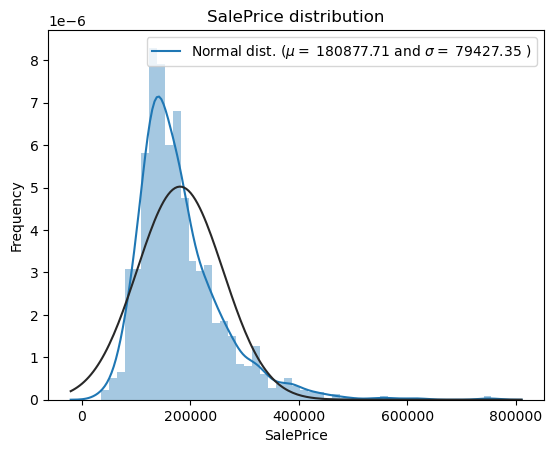

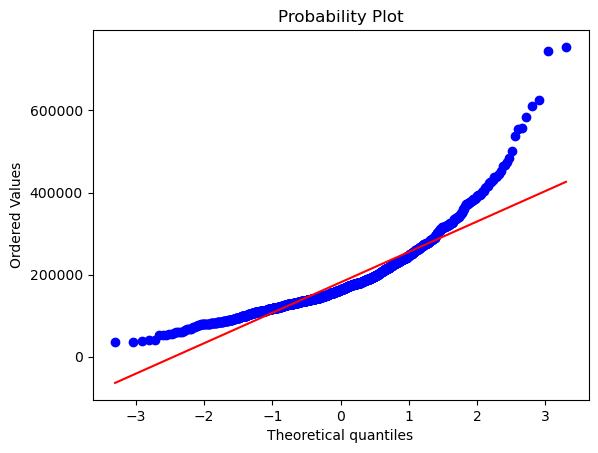

In [14]:
sns.distplot(df_train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(df_train['SalePrice'], plot=plt)
plt.show()

The target is skewed to lower house prices. One of the assumptions of a linear model is Normality, that is the residuals (the difference between the predicted and observed values) to closely resemble a normal distribution (See post from <a href="https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/">Statology</a>), and log-transforming the target and features will help achieve normality.

Although skewed data in theory shouldn't impact tree based models such as XGBoost, I do plan on testing out additional regression models in the future, so it's worth normalizing the data now. Also, most of the times this will lead to more accurate model, regardless of the type of model used.


 mu = 12.02 and sigma = 0.40



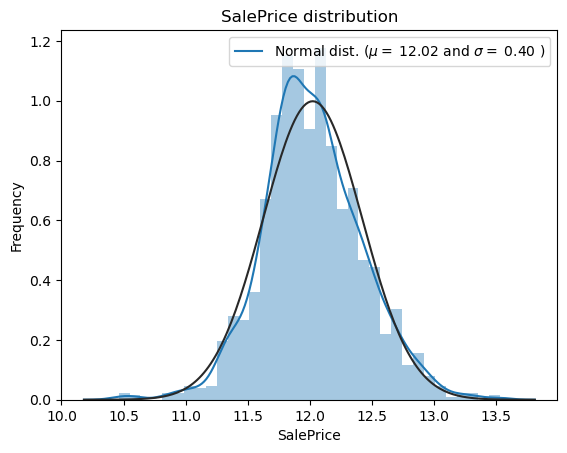

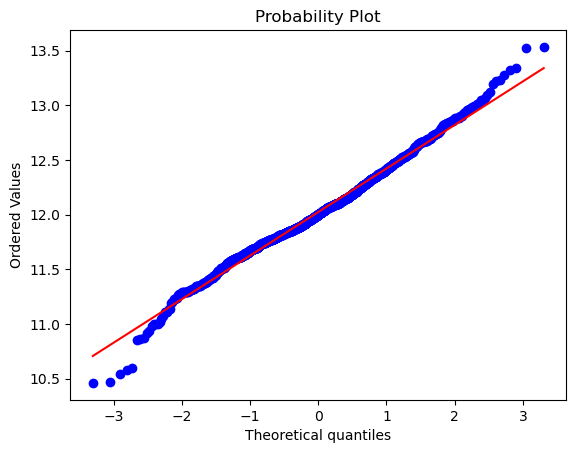

In [15]:
df_train["SalePrice"] = np.log(df_train["SalePrice"])

sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(df_train['SalePrice'], plot=plt)
plt.show()

Now the output looks much closer to having a normal distribution. It is important to check that after any transformations made to skewed data, that the transformed output represents a normal distribution, as that is the whole point of applying the transformation in the first place. 



### Check if the features have the right data types

Let's combine the dataset and look at all the numeric datatypes first.

In [16]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(df_all.shape))

all_data size is : (2919, 78)


In [17]:
df_all.dtypes.value_counts()


object     42
int64      25
float64    11
dtype: int64

In [18]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_all_numeric = df_all.select_dtypes(include=numerics)
df_all_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,2.0,548.0,0,61,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,2.0,460.0,298,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,2.0,608.0,0,42,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,3.0,642.0,0,35,272,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,3.0,836.0,192,84,0,0,0,0,12,2008


In [19]:
df_all_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MoSold', 'YrSold'],
      dtype='object')

The 'Id' column can be dropped, since it is just a unique identifier of records and is not a feature.

From reading the description, the following features should be categorical instead of numeric:
MSSubClass, YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold

In [20]:
df_all = df_all.drop(columns = ['Id'])
df_all_numeric = df_all_numeric.drop(columns = ['Id'])

### Feature Engineering

Although features describing years and months of the house are categorical, the age (i.e. difference in time between two year/month values) are numeric. Often the age of the house is a more important consideration for buyers than when it was built or remodelled. It could be beneficial to feature engineer additional age variables to the dataset.

In [21]:
df_all['HousePurchaseAge'] = df_all['YrSold'] - df_all['YearBuilt']
df_all['GaragePurchaseAge'] = df_all['YrSold'] - df_all['GarageYrBlt']
df_all['RemodAddAge'] = df_all['HousePurchaseAge'] - (df_all['YearRemodAdd'] - df_all['YearBuilt'])

Double check that these variables should all be numeric values above 0

In [22]:
df_all.loc[(df_all['HousePurchaseAge']<0) | (df_all['GaragePurchaseAge']<0) | (df_all['RemodAddAge']<0)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,HousePurchaseAge,GaragePurchaseAge,RemodAddAge
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,10,2007,New,Partial,0,0.0,-1
2295,60,RL,134.0,16659,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,6,2007,New,Partial,0,0.0,-1
2549,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,10,2007,New,Partial,-1,-1.0,-2
2592,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,NaN,NaN,9,2007,New,Partial,1,-200.0,0


Interesting, four of the houses had a negative remodelled age. Let's take a closer look at these records

In [27]:
df_all.loc[(df_all['RemodAddAge']<0), ['YrSold', 'YearRemodAdd','HousePurchaseAge','YearBuilt', 'RemodAddAge','GarageYrBlt','GaragePurchaseAge' ]]

,YrSold,YearRemodAdd,HousePurchaseAge,YearBuilt,RemodAddAge,GarageYrBlt,GaragePurchaseAge
523,2007,2008,0,2007,-1,2007.0,0.0
2295,2007,2008,0,2007,-1,2007.0,0.0
2549,2007,2009,-1,2008,-2,2008.0,-1.0


In [28]:
df_all.loc[(df_all['GaragePurchaseAge']<0), ['YrSold', 'YearRemodAdd','HousePurchaseAge','YearBuilt', 'RemodAddAge','GarageYrBlt','GaragePurchaseAge' ]]

,YrSold,YearRemodAdd,HousePurchaseAge,YearBuilt,RemodAddAge,GarageYrBlt,GaragePurchaseAge
2549,2007,2009,-1,2008,-2,2008.0,-1.0
2592,2007,2007,1,2006,0,2207.0,-200.0


The newly engineered remodAddAge feature correctly calculated the House Age after the remodel date, given that the year for which the sale occurred was one year before the year of remodelling. 

This means that at the time of sale, the house was not remodelled. By default, the value of RemodAddAge should be the same as the year it was built, which is 2007, so the remodelled age for this record should be 0.

One of the records also has a 'YearBuilt' greater than 'YrSold'. Let's set the 'YearBuilt' to be the same as 'YrSold'.

In addition, one record has a 'GarageYrBult' at 2207, which is probably a typo. We can assume it was actually built in 2007.

We need to create a logic for the test data to set the GarageYrBlt and YearRemodAdd to the same as YearBuilt if they are higher than YrSold.

In [29]:
df_all.loc[(df_all['YearBuilt']>df_all['YrSold']), 'YearBuilt'] = df_all['YrSold']
df_all['HousePurchaseAge'] = df_all['YrSold'] - df_all['YearBuilt']
df_all.loc[(df_all['YearRemodAdd']>df_all['YrSold']), 'YearRemodAdd'] = df_all['YearBuilt']
df_all['RemodAddAge'] = df_all['HousePurchaseAge'] - (df_all['YearRemodAdd'] - df_all['YearBuilt'])

df_all.loc[(df_all['GarageYrBlt']>df_all['YrSold']), 'GarageYrBlt'] = df_all['YrSold']
df_all['GaragePurchaseAge'] = df_all['YrSold'] - df_all['GarageYrBlt']



Now let's check we don't have any more negative Ages.

In [30]:
df_all.loc[(df_all['HousePurchaseAge']<0) | (df_all['GaragePurchaseAge']<0) | (df_all['RemodAddAge']<0)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,HousePurchaseAge,GaragePurchaseAge,RemodAddAge


Now that we have created numeric features from the dataset, we can convert the MSSubClass, YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold values to object type

In [31]:
for i in ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']:
    df_all[i] = df_all[i].astype('object')


In [32]:
df_all_object = df_all.select_dtypes(include='object')
df_all_object.loc[:,['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']].head()

,MSSubClass,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold
0,60,2003,2003,2003.0,2,2008
1,20,1976,1976,1976.0,5,2007
2,60,2001,2002,2001.0,9,2008
3,70,1915,1970,1998.0,2,2006
4,60,2000,2000,2000.0,12,2008


Good, the five values have now been converted to categorical values. Now let's take a look at all the other categorical values

In [33]:
df_all_object.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

Some of the Quality features can be converted to numeric type. The following code is taken from 's notebook to convert categorical features to numeric types:

In [34]:
df_all = df_all.replace({
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [35]:
transformed_categorical_features = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'LandSlope', 'LotShape', 'PoolQC', 'Utilities']
df_all[transformed_categorical_features] = df_all[transformed_categorical_features].fillna(0)
df_all[transformed_categorical_features].isna().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
ExterCond       0
ExterQual       0
FireplaceQu     0
Functional      0
GarageCond      0
GarageQual      0
HeatingQC       0
KitchenQual     0
LandSlope       0
LotShape        0
PoolQC          0
Utilities       0
dtype: int64

In [36]:
for i in transformed_categorical_features:
    df_all[i] = df_all[i].astype('int')

### Understand features and correlations

#### Now that we transformed SalePrice, and the feature types have been corrected, we can examine the correlations of all other attributes to the target variable. 
There are several ways we can do this. A good library that we can use is the sweetviz library, which automatically generates a report that plots all the features and their correlation against the target variable.

In [37]:
my_report = sv.analyze(pd.concat([df_all[:ntrain], df_train['SalePrice']], axis=1), target_feat = 'SalePrice')
my_report.show_html() 

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


We can also plot a heatmap:

In [38]:
df_all.corr().style.background_gradient(cmap = plt.get_cmap('bwr'))


,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,HousePurchaseAge,GaragePurchaseAge,RemodAddAge
LotFrontage,1.000000,0.489896,-0.172441,-0.034486,-0.061969,0.217645,-0.075508,0.221079,0.164726,-0.012955,0.113472,-0.005806,0.187419,0.046159,0.219408,0.011233,0.047431,0.113714,0.354822,0.084353,0.458247,0.026545,0.004894,0.382462,0.113245,-0.025629,0.181668,0.039452,0.234892,0.004676,0.182126,0.349513,-0.015749,0.261970,0.246242,0.310587,0.359786,0.121551,0.111086,0.122070,0.164896,0.011509,0.028289,0.075858,0.174119,0.161825,-0.122951,-0.078666,-0.091866
LotArea,0.489896,1.000000,-0.288566,-0.054429,-0.334575,0.100541,-0.035617,0.125596,0.061780,0.003708,0.059864,0.003586,0.197737,0.041189,0.194031,0.055780,0.084059,0.021362,0.254138,0.011574,0.332460,0.031515,0.000554,0.284519,0.128349,0.026292,0.125826,0.034244,0.132801,-0.020854,0.080310,0.213802,-0.073824,0.261185,0.189278,0.180434,0.213251,0.085901,0.075589,0.158045,0.104797,0.020974,0.015995,0.054375,0.093708,0.077362,-0.025101,0.006781,-0.022945
LotShape,-0.172441,-0.288566,1.000000,0.010820,0.111579,-0.252348,0.083924,-0.108634,-0.218174,0.011354,-0.242429,-0.095373,-0.192815,-0.137443,-0.165342,-0.036050,-0.044534,-0.018177,-0.206133,-0.147909,-0.196557,-0.082773,0.023539,-0.220362,-0.078798,-0.045166,-0.203880,-0.136074,-0.050597,0.092535,-0.184843,-0.134664,-0.039961,-0.187497,-0.191927,-0.228589,-0.204302,-0.129702,-0.122551,-0.161065,-0.095921,0.090954,-0.020153,-0.050613,-0.027806,-0.038622,0.277601,0.241262,0.208724
Utilities,-0.034486,-0.054429,0.010820,1.000000,-0.006674,0.036979,0.054480,-0.001037,0.042381,0.040259,0.057191,0.060049,0.019355,0.028353,0.028408,0.008846,-0.003871,-0.011437,0.016473,0.030669,-0.001795,0.024228,0.003123,0.019419,0.025298,-0.017424,0.031708,0.023342,0.024772,0.006410,0.014373,0.012815,0.047915,-0.019247,-0.010797,0.006754,0.008295,-0.008583,-0.008282,0.011249,0.006526,-0.016577,0.003189,-0.016778,0.001949,0.001699,-0.036347,-0.020689,-0.048275
LandSlope,-0.061969,-0.334575,0.111579,-0.006674,1.000000,0.023436,-0.010349,-0.018093,0.033911,0.012751,-0.019815,-0.018693,-0.244669,-0.047555,-0.116014,-0.070711,-0.083126,0.107312,-0.044817,0.029953,-0.071674,0.035517,-0.001989,-0.025666,-0.106388,-0.069366,0.062726,0.004663,0.085498,0.038493,0.012493,0.049063,0.074471,-0.122074,-0.063609,-0.001159,-0.011347,-0.015876,-0.011625,-0.088160,0.013464,-0.013544,-0.016980,-0.061651,0.008094,-0.017612,-0.042036,-0.057664,-0.044505
OverallQual,0.217645,0.100541,-0.252348,0.036979,0.023436,1.000000,-0.093847,0.432947,0.733355,0.006353,0.643676,0.272334,0.326934,0.283341,0.281810,-0.010985,-0.042771,0.275175,0.549294,0.474355,0.479152,0.245596,-0.048393,0.575126,0.164543,-0.040732,0.528483,0.272668,0.073075,-0.159325,0.674244,0.389761,0.184124,0.390753,0.484378,0.600744,0.565122,0.299723,0.289864,0.255317,0.298084,-0.139256,0.018715,0.042910,0.030740,0.079849,-0.597500,-0.576171,-0.572714
OverallCond,-0.075508,-0.035617,0.083924,0.054480,-0.010349,-0.093847,1.000000,-0.136007,-0.151619,0.404190,-0.179538,0.092835,-0.087172,-0.007369,-0.050418,0.094408,0.041501,-0.138202,-0.174002,-0.009676,-0.157418,0.005494,0.009048,-0.116569,-0.042133,0.084181,-0.215504,-0.088577,-0.008477,-0.086700,-0.048633,-0.092027,0.130679,-0.030999,-0.068980,-0.181787,-0.154149,0.022372,0.047114,0.020123,-0.068978,0.071044,0.043739,0.043713,-0.016876,-0.022985,0.369237,0.330703,-0.045801
MasVnrArea,0.221079,0.125596,-0.108634,-0.001037,-0.018093,0.432947,-0.136007,1.000000,0.371305,-0.009999,0.304802,0.093136,0.220526,0.213318

### Check null values

In [39]:
df_all[df_all.columns[df_all.isna().any()].tolist()].isna().sum().sort_values(ascending=False)

Alley                2721
Fence                2348
LotFrontage           486
GaragePurchaseAge     159
GarageFinish          159
GarageYrBlt           159
GarageType            157
MasVnrType             24
MasVnrArea             23
MSZoning                4
BsmtFullBath            2
BsmtHalfBath            2
TotalBsmtSF             1
BsmtUnfSF               1
BsmtFinSF2              1
BsmtFinSF1              1
Exterior2nd             1
GarageCars              1
GarageArea              1
Exterior1st             1
SaleType                1
Electrical              1
dtype: int64

##### PoolQC

PoolQC has the most null values. From the sweetviz report, the number of non-null 
It may be a good idea to drop the column, since most houses do not have a pool, and looking at the poolarea, those 7 houses that do have a pool do not appear to have a strong correlation between poolarea and SalePrice, and that one house with poolArea = 555 with a high SalePrice is an outlier.

However, I think that if a house has a pool it should be a big contributor to the value of the house. Therefore, we can add a 'HasPool' variable just to indicate that the house has a pool, so we can delete the PoolQC and PoolArea variable.

In [40]:
df_all['HasPool'] = (df_all['PoolArea'] > 0).astype(object)
df_all.drop(columns = ['PoolArea','PoolQC'], inplace=True)

##### Alley

In [41]:
df_all['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

The description for Alley says NA indicates no alley access, but there are no 'NA' values in this column. We can assume any null values indicate no alley access and fill them with 'NA'.

In [42]:
df_all.loc[df_all['Alley'].isna(), 'Alley'] = 'NA'

##### Fence

In [43]:
df_all['Fence'].value_counts()

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

Just like Alley, we can fill the null values with 'NA' 

In [44]:
df_all.loc[df_all['Fence'].isna(), 'Fence'] = 'NA'

##### LotFrontage

From the sweetviz report, LotFrontage has an evident correlation with SalePrice, so it could be a good predictor. Since LotFrontage is a numeric measurement, let's just try replacing the values as the median of all LotFrontages.

In [45]:
df_all.loc[df_all['LotFrontage'].isna(), 'LotFrontage'] = df_all['LotFrontage'].median()

##### Garage

There are 81 houses that do not have a garage, and are therefore missing all the garage related features. We can fill them with 'NA' if it is a categorical feature.

Note that because there are some null 'GarageYrBlt' values, their 'GaragePurchaseAge' will also be null. Let's just replace these with the median value of 'GaragePurchaseAge'.

In [46]:
df_all.loc[df_all['GarageCond'].isna(), 'GarageCond'] = 'NA'
df_all.loc[df_all['GarageQual'].isna(), 'GarageQual'] = 'NA'
df_all.loc[df_all['GarageFinish'].isna(), 'GarageFinish'] = 'NA'
df_all.loc[df_all['GarageYrBlt'].isna(), 'GarageYrBlt'] = 'NA'
df_all.loc[df_all['GarageType'].isna(), 'GarageType'] = 'NA'
df_all.loc[df_all['GaragePurchaseAge'].isna(), 'GaragePurchaseAge'] = df_all['GaragePurchaseAge'].median()

##### Basement, Masionary, and Electrical

Similarly, fill the missing values with 'NA' or 0. 

In [47]:
df_all.loc[df_all['BsmtHalfBath'].isna(), 'BsmtHalfBath'] = 0
df_all.loc[df_all['BsmtFullBath'].isna(), 'BsmtFullBath'] = 0
df_all.loc[df_all['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['BsmtUnfSF']

##### Other variables
The remaining null variables can be filled using a for loop: 

In [48]:
for i in df_all.columns:
    if str(df_all[i].dtype) == 'object' or str(df_all[i].dtype) == 'string':
        df_all.loc[df_all[i].isna(), i] = 'NA'
    else:
        if i.find('Area') > 0 or i.find('SF') > 0:
            df_all.loc[df_all[i].isna(), i] = 0
        else:
            df_all.loc[df_all[i].isna(), i] = df_all[i].median()

Double check no other null values exists:

In [49]:
df_all[df_all.columns[df_all.isna().any()].tolist()].isna().sum().sort_values(ascending=False)

Series([], dtype: float64)

### Remove outliers

In [50]:
df_all[:ntrain].select_dtypes(include=numerics).apply(lambda x: x.corr(df_train['SalePrice'])).sort_values(ascending=False)

OverallQual          0.817184
GrLivArea            0.700786
GarageCars           0.680819
ExterQual            0.679063
KitchenQual          0.668196
GarageArea           0.650940
BsmtQual             0.616218
TotalBsmtSF          0.612227
1stFlrSF             0.597051
FullBath             0.594634
FireplaceQu          0.546419
TotRmsAbvGrd         0.534063
Fireplaces           0.489385
HeatingQC            0.473978
MasVnrArea           0.426871
BsmtFinSF1           0.371931
BsmtExposure         0.337165
BsmtFinType1         0.334739
LotFrontage          0.334199
WoodDeckSF           0.334141
OpenPorchSF          0.321163
2ndFlrSF             0.319065
HalfBath             0.313953
BsmtCond             0.275055
LotArea              0.257006
BsmtFullBath         0.236389
BsmtUnfSF            0.222164
BedroomAbvGr         0.208974
Functional           0.136776
ScreenPorch          0.121014
3SsnPorch            0.054870
ExterCond            0.049123
BsmtFinType2         0.014079
Utilities 

We can see all the features we added, including the Age features we added previously, all correlate with SalePrice better against most other features (Age features correlate negatively)

Let's visualize in more detail the top three most correlated features with SalePrice

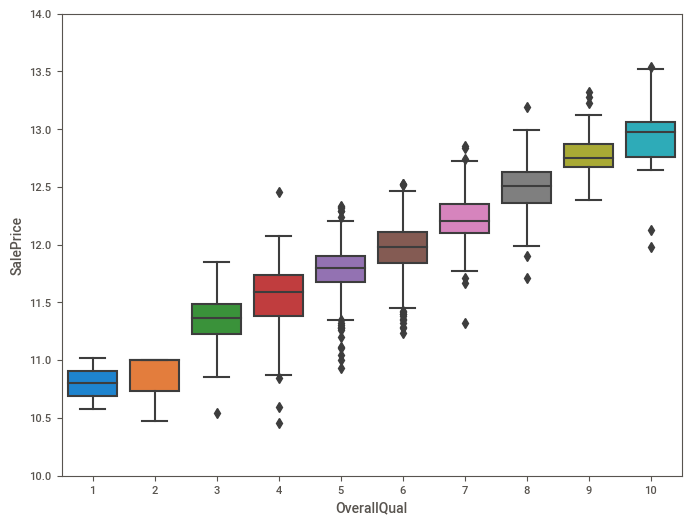

In [51]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)
fig.axis(ymin=10, ymax=14);

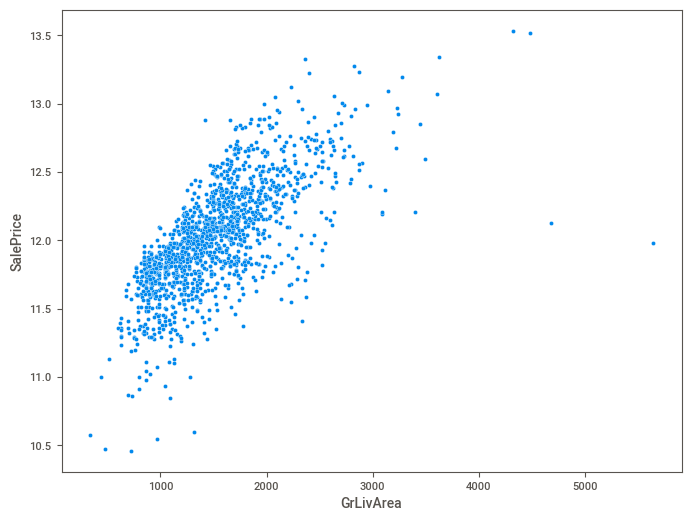

In [52]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
fig.axis();

The two houses with more than 700k saleprice do not seem to be outliers they do have a large Above ground living area.
The two houses with more than 4500 sqft Above ground living area but with lower than $200k sale price appear to be outliers. 


In [53]:
df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<12.5)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,0,0,NaN,NaN,10,2007,New,Partial,12.126759
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,0,0,480,Gd,NaN,1,2008,New,Partial,11.982929


If we were to delete these two rows from the training data, we need to note their indexes so we can delete them from df_all too. In this case, the two rows have indexes 523 and 1298.

In [54]:
df_train.drop(df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<12.5)].index, inplace=True)

In [55]:
df_all.drop([523,1298], inplace = True)

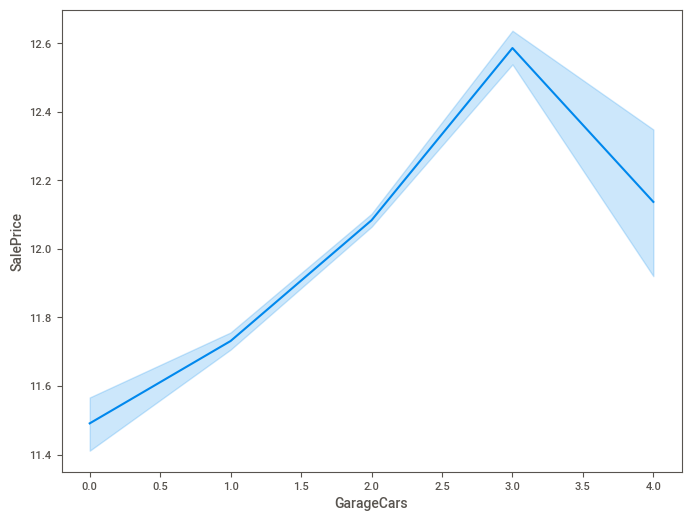

In [56]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.lineplot(x='GarageCars', y='SalePrice', data=df_train)
fig.axis();

##### A little more feature engineering
From the correlations to the target, the 'GarageCars' and 'GarageArea' both have a relatively high correlation with 'SalePrice', and they have an even higher correlation with each other. 'GarageCars' is a more accurate description for a Garage, because the purpose of having large areas in a garage is to fit more cars. It also has a higher correlation to 'SalePrice' than 'GarageArea' as well, therefore we can drop the 'GarageArea' column.

In [57]:
df_all.drop(columns = ['GarageArea'], inplace=True)

The corrleations also show that SalePrice correlates relatively well with most of the Area measurements, which makes sense because larger houses generally are more expensive. We can generate another feature, which is the total floor area, combining the basement, first floor, and second floor.

In [58]:
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

This means we can also have two more features, total bathrooms and total half bathrooms, since larger houses generally will have more bathrooms.

In [59]:
df_all['TotalBath'] = df_all['BsmtFullBath'] + df_all['FullBath']
df_all['TotalHalfBath'] = df_all['BsmtHalfBath'] + df_all['HalfBath']

From visualizing the Sweetviz report, there appears to be several outliers in some of the numerical features, where the SalePrice does not correlate to the feature well. Let's inspect them in more detail.

In [60]:
ix = df_train.corr().sort_values('SalePrice', ascending=False).index
pd.set_option('display.max_columns', None)


In [61]:
df_train.loc[df_train['MasVnrArea'] == 1600, ix]

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,Id,YrSold,OverallCond,LowQualFinSF,MSSubClass,KitchenAbvGr,EnclosedPorch
297,12.384219,7,1950,2,576,975,975,2,1997,1998,1997.0,7,1,1600.0,649,66.0,0,10,975,1,7399,0,326,3,198,0,6,0,0,0,298,2007,5,0,60,1,0


In [62]:
df_train.loc[df_train['LotFrontage'] > 300, ix]

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,Id,YrSold,OverallCond,LowQualFinSF,MSSubClass,KitchenAbvGr,EnclosedPorch
934,12.396693,7,2069,2,505,585,2069,2,1960,2007,1960.0,9,1,0.0,425,313.0,0,0,0,0,27650,1,160,4,0,0,11,0,0,0,935,2008,7,0,20,1,0


In [63]:
df_train.loc[(df_train['WoodDeckSF'] > 700) & (df_train['WoodDeckSF'] < 750), ix]

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,Id,YrSold,OverallCond,LowQualFinSF,MSSubClass,KitchenAbvGr,EnclosedPorch
1068,11.927681,6,2521,2,576,942,1291,2,1973,1973,1973.0,10,1,0.0,837,42.0,728,20,1230,1,3964,1,105,5,0,0,6,0,0,0,1069,2006,4,0,160,1,0
1459,11.901583,5,1256,1,276,1256,1256,1,1965,1965,1965.0,6,0,0.0,830,75.0,736,68,0,1,9937,1,136,3,0,0,6,0,290,0,1460,2008,6,0,20,1,0


In [64]:
df_train.loc[(df_train['OpenPorchSF'] > 500) & (df_train['SalePrice'] < 10.5), ix]

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,Id,YrSold,OverallCond,LowQualFinSF,MSSubClass,KitchenAbvGr,EnclosedPorch
495,10.460242,4,720,0,0,720,720,1,1920,1950,NaN,4,0,0.0,495,60.0,0,523,0,0,7879,0,225,2,0,0,11,0,0,0,496,2009,5,0,30,1,115


We can drop these rows from df_train and df_all.

In [65]:
df_train.drop(df_train.loc[df_train['MasVnrArea'] == 1600].index, inplace=True)
df_train.drop(df_train.loc[df_train['LotFrontage'] > 300].index, inplace=True)
df_train.drop(df_train.loc[(df_train['WoodDeckSF'] > 700) & (df_train['WoodDeckSF'] < 750)].index, inplace=True)
df_train.drop(df_train.loc[(df_train['OpenPorchSF'] > 500) & (df_train['SalePrice'] < 10.5)].index, inplace=True)

In [66]:
df_all.drop([297,934,1068,1459,495], inplace = True)
ntrain = ntrain - 7

### Even MORE feature engineering

From the sweetviz report, a lot of the features have highly skewed data, especially those quality and condition features that were transformed earlier. We can create less granular features to prevent these skewed features from overfitting the model. 

The following section is taken from <a href="https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook">Juliencs's notebook</a>

In [67]:
df_all["SimplOverallQual"] = df_all.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df_all["SimplOverallCond"] = df_all.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df_all["SimplGarageCond"] = df_all.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df_all["SimplGarageQual"] = df_all.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df_all["SimplFireplaceQu"] = df_all.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_all["SimplFireplaceQu"] = df_all.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_all["SimplFunctional"] = df_all.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
df_all["SimplKitchenQual"] = df_all.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_all["SimplHeatingQC"] = df_all.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
df_all["SimplBsmtFinType1"] = df_all.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
df_all["SimplBsmtFinType2"] = df_all.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
df_all["SimplBsmtCond"] = df_all.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
df_all["SimplBsmtQual"] = df_all.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
df_all["SimplExterCond"] = df_all.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
df_all["SimplExterQual"] = df_all.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })



We can also create additional features based on those that have high correlations with the target. 

In [68]:
# Create new features
# 3* Polynomials on the top 10 existing features
df_all["OverallQual-s2"] = df_all["OverallQual"] ** 2
df_all["OverallQual-s3"] = df_all["OverallQual"] ** 3
df_all["OverallQual-Sq"] = np.sqrt(df_all["OverallQual"])
df_all["TotalSF-2"] = df_all["TotalSF"] ** 2
df_all["TotalSF-3"] = df_all["TotalSF"] ** 3
df_all["TotalSF-Sq"] = np.sqrt(df_all["TotalSF"])
df_all["1stFlrSF-2"] = df_all["1stFlrSF"] ** 2
df_all["1stFlrSF-3"] = df_all["1stFlrSF"] ** 3
df_all["1stFlrSF-Sq"] = np.sqrt(df_all["1stFlrSF"])
df_all["GrLivArea-2"] = df_all["GrLivArea"] ** 2
df_all["GrLivArea-3"] = df_all["GrLivArea"] ** 3
df_all["GrLivArea-Sq"] = np.sqrt(df_all["GrLivArea"])
df_all["SimplOverallQual-s2"] = df_all["SimplOverallQual"] ** 2
df_all["SimplOverallQual-s3"] = df_all["SimplOverallQual"] ** 3
df_all["SimplOverallQual-Sq"] = np.sqrt(df_all["SimplOverallQual"])
df_all["ExterQual-2"] = df_all["ExterQual"] ** 2
df_all["ExterQual-3"] = df_all["ExterQual"] ** 3
df_all["ExterQual-Sq"] = np.sqrt(df_all["ExterQual"])
df_all["GarageCars-2"] = df_all["GarageCars"] ** 2
df_all["GarageCars-3"] = df_all["GarageCars"] ** 3
df_all["GarageCars-Sq"] = np.sqrt(df_all["GarageCars"])
df_all["TotalBath-2"] = df_all["TotalBath"] ** 2
df_all["TotalBath-3"] = df_all["TotalBath"] ** 3
df_all["TotalBath-Sq"] = np.sqrt(df_all["TotalBath"])
df_all["KitchenQual-2"] = df_all["KitchenQual"] ** 2
df_all["KitchenQual-3"] = df_all["KitchenQual"] ** 3
df_all["KitchenQual-Sq"] = np.sqrt(df_all["KitchenQual"])
df_all["SimplExterQual-2"] = df_all["SimplExterQual"] ** 2
df_all["SimplExterQual-3"] = df_all["SimplExterQual"] ** 3
df_all["SimplExterQual-Sq"] = np.sqrt(df_all["SimplExterQual"])



Now let's normalize some of our skewed datasets，as it helps with achieving Normality, which we discussed earlier. 

Another interpretation of normalizing features is that without any transformations to address skewed data, "the model is under
more pressure to fit very different target values under very small changes in the input" (From the <a href='https://www.amazon.com.au/Feature-Engineering-Machine-Learning-Principles-ebook/dp/B07BNX4MWC/'>Feature Engineering Machine Learning Principles</a> ebook, page 20), which means the model will likely produce predictions with larger variance and inaccuracy for features in the 'tail' of the skewed dataset. 

The section below is take from Serigne's Stacked Regressions : Top 4% on LeaderBoard notebook:
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard


In [70]:
df_all_numeric = df_all.dtypes[df_all.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_all[df_all_numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)


Skew in numerical features: 



,Skew
1stFlrSF-3,20.000070
TotalSF-3,16.871686
LotArea,13.134991
LowQualFinSF,12.073977
3SsnPorch,11.362112


In [71]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_all[feat] = boxcox1p(df_all[feat], lam)

There are 91 skewed numerical features to Box Cox transform


Now let's visualise the correlations again

In [72]:
df_all[:ntrain].select_dtypes(include=numerics).apply(lambda x: x.corr(df_train['SalePrice'])).sort_values(ascending=False)

TotalSF-3            0.829698
TotalSF-2            0.827598
TotalSF              0.824121
TotalSF-Sq           0.822108
OverallQual-s3       0.814643
                       ...   
EnclosedPorch       -0.197350
LotShape            -0.276862
RemodAddAge         -0.550024
GaragePurchaseAge   -0.563128
HousePurchaseAge    -0.619943
Length: 91, dtype: float64

Interestingly, although most features became more correlated with the target variable, some of the features became less correlated to the target after removing outliers and applying box-cox transform (e.g. BsmtFinSF1 went from 0.37 to 0.23). 

## Building a predictive model

Now we have cleaned and transformed the data, removed outliers, and created additional useful features, we are ready to build our prediction model!

In [73]:
df_all = pd.get_dummies(df_all, drop_first=True)


Let's create an initial copy of the training dataset with encoded categorical values. We may need to create additional copies later on.

In [74]:
df_all_1 = df_all.copy()

In [75]:
len(list(df_all.columns))

567

In [76]:
df_train_v1 = df_all[:ntrain]
df_train_v1_target = df_train['SalePrice']

In [77]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
def cv_rmse(model, X, Y):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

Let's see how a default XGBoost regression model works on our dataset.

In [78]:
model_xgb = xgb.XGBRegressor()
score = cv_rmse(model_xgb, df_train_v1, df_train_v1_target)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.1344 (0.0075)


The initial model generated an average  mean squared error of 0.1344, which is not a bad score.

#### Sparse features

From the sweetviz report, many of the features had low volumes of data in some of its categories. This means when they were dummy encoded, they would have turned to sparse features, which are features with mostly '0' values. Sparse features can add noise to the dataset and reduce training accuracy. 

We can run a loop to see if there is a threshold of features where the training accuracy improves if we drop columns with less than a certain number of non-zero values:

In [79]:
for i in range(10,220,10):
    
    df_train_v2 = df_all[:ntrain].drop([col for col, val in df_all[:ntrain].sum().iteritems() if val < i], axis=1)
    score = cv_rmse(model_xgb, df_train_v2, df_train_v1_target)
    print("dropped columns with less than {} non-null values, xgboost: {:.4f} ({:.4f})".format(i, score.mean(), score.std()))


dropped columns with less than 10 non-null values, xgboost: 0.1342 (0.0120)
dropped columns with less than 20 non-null values, xgboost: 0.1317 (0.0118)
dropped columns with less than 30 non-null values, xgboost: 0.1326 (0.0092)
dropped columns with less than 40 non-null values, xgboost: 0.1344 (0.0089)
dropped columns with less than 50 non-null values, xgboost: 0.1347 (0.0086)
dropped columns with less than 60 non-null values, xgboost: 0.1355 (0.0105)
dropped columns with less than 70 non-null values, xgboost: 0.1364 (0.0086)
dropped columns with less than 80 non-null values, xgboost: 0.1354 (0.0106)
dropped columns with less than 90 non-null values, xgboost: 0.1356 (0.0082)
dropped columns with less than 100 non-null values, xgboost: 0.1362 (0.0083)
dropped columns with less than 110 non-null values, xgboost: 0.1363 (0.0087)
dropped columns with less than 120 non-null values, xgboost: 0.1374 (0.0129)
dropped columns with less than 130 non-null values, xgboost: 0.1379 (0.0107)
dropped 

From the loop, the model improved the most when columns with values less than a sum of 20 are dropped. Let's use this updated training data from now on.

In [80]:
df_train_v2 = df_all[:ntrain].drop([col for col, val in df_all[:ntrain].sum().iteritems() if val < 20], axis=1)

In [81]:
score = cv_rmse(model_xgb, df_train_v2, df_train_v1_target)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.1317 (0.0118)


### Creating individual models

Instead of using a single regression model, we can create a stacked model with multiple lachine learning algorithms. Stacked models are often better than individual models, because by combining several heterogeneous models together, errors made by one model can be mitigated by many of the other models, assuming that each individual model are slightly different to each other.

In this notebook we will use five regression algorithms: XGBoost, LightGBM, CatBoost, Lasso, and Ridge Regression.

##### XGBoost

We can perform a GridSearch over the model to find the best hyperparameters for the model. 

In [82]:
param_grid_xgb = {
    'max_depth': [3,6,9],
    'learning_rate':[0.05, 0.1, 0.3],
    'reg_alpha':[0.01, 0.1, 0.5],
    'reg_lambda':[0.01, 0.1, 0.5],
    'gamma':[0.01, 0.05, 0.1],
    'n_estimators':[100, 1000, 2000],
    'min_child_weight':[1, 2, 5]
}

optimal_parameters_xgb = GridSearchCV(
    estimator = xgb.XGBRegressor(),
    param_grid = param_grid_xgb,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    cv = 4
)


In [83]:
# Commenting this part out as the verbose=2 generates 8748 of rows of text, which will 
# affect the way the notebook looks on Kaggle.

# optimal_parameters_xgb.fit(df_train_2, df_train_1_target)


In [84]:
#Results from the previous cell
optimal_parameters_xgb = {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.01}


In [86]:
model_xgb = xgb.XGBRegressor(**optimal_parameters_xgb)

In [88]:
score = cv_rmse(model_xgb, df_train_v2, df_train_v1_target)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.1226 (0.0087)


The model had a lower mean squared error after the rigourous hyperparameter search. Now we can further fine-tune the hyperparameters to be closer to the previously generaged best hyperparameters

In [89]:
param_grid_xgb_v2 = {
    'max_depth': [3,4,5],
    'learning_rate':[0.1],
    'reg_alpha':[0.07, 0.1, 0.2],
    'reg_lambda':[0.01, 0.04, 0.07],
    'gamma':[0.01, 0.02, 0.04],
    'n_estimators':[1000, 1500],
    'min_child_weight':[1]
}

optimal_parameters_xgb_v2 = GridSearchCV(
    estimator = xgb.XGBRegressor(),
    param_grid = param_grid_xgb_v2,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 4
)


In [90]:
optimal_parameters_xgb_v2.fit(df_train_v2, df_train_v1_target)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [91]:
print(optimal_parameters_xgb_v2.best_params_)

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.07, 'reg_lambda': 0.01}


In [92]:
model_xgb_v2 = xgb.XGBRegressor(**optimal_parameters_xgb_v2.best_params_)

In [93]:
score_xgb_v2 = cv_rmse(model_xgb_v2, df_train_v2, df_train_v1_target)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.1226 (0.0087)


In [94]:
model_xgb_v2.fit(df_train_v2, df_train_v1_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.07, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

The second round of hyperparameter tuning revealed a better reg_alpha parameter, but unfortunately barely improved the model.

##### LightGBM

In [95]:
param_grid_lgbm = {
    'num_leaves': [4,6,8],
    'learning_rate':[0.05, 0.1, 0.15],
    'n_estimators':[4000, 5000, 6000],
    'max_bin':[200,300,400],
}

optimal_parameters_lgbm = GridSearchCV(
    estimator = lgbm.LGBMRegressor(),
    param_grid = param_grid_lgbm,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 4
)

In [96]:
optimal_parameters_lgbm.fit(df_train_v2, df_train_v1_target)

GridSearchCV(cv=4, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_bin': [200, 300, 400],
                         'n_estimators': [4000, 5000, 6000],
                         'num_leaves': [4, 6, 8]},
             scoring='neg_root_mean_squared_error')

In [97]:
print(optimal_parameters_lgbm.best_params_)

{'learning_rate': 0.05, 'max_bin': 200, 'n_estimators': 4000, 'num_leaves': 4}


In [98]:
model_lgbm = lgbm.LGBMRegressor(**optimal_parameters_lgbm.best_params_)

In [99]:
score_lgbm = cv_rmse(model_lgbm, df_train_v2, df_train_v1_target)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))

lightgbm: 0.1226 (0.0087)


In [100]:
model_lgbm.fit(df_train_v2, df_train_v1_target)

LGBMRegressor(learning_rate=0.05, max_bin=200, n_estimators=4000, num_leaves=4)

##### Catboost

In [101]:
param_grid_cb = {
     'depth': [5,6,7,8],
     'learning_rate': [0.05, 0.1, 0.2, 0.3],
     'iterations': [50, 75, 100, 200]
    }


optimal_parameters_cb = GridSearchCV(
    estimator = cb.CatBoostRegressor(),
    param_grid = param_grid_cb,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 4
)

In [102]:
optimal_parameters_cb.fit(df_train_v2, df_train_v1_target, silent=True)

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000025B051A1C60>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8],
                         'iterations': [50, 75, 100, 200],
                         'learning_rate': [0.05, 0.1, 0.2, 0.3]},
             scoring='neg_root_mean_squared_error')

In [103]:
print(optimal_parameters_cb.best_params_)

{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


In [104]:
model_cb = cb.CatBoostRegressor(**optimal_parameters_cb.best_params_)

In [105]:
score_cb = cv_rmse(model_cb, df_train_v2, df_train_v1_target)
print("catboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

0:	learn: 0.3715759	total: 5.19ms	remaining: 1.03s
1:	learn: 0.3483960	total: 11.9ms	remaining: 1.18s
2:	learn: 0.3261103	total: 16.4ms	remaining: 1.07s
3:	learn: 0.3056345	total: 21ms	remaining: 1.03s
4:	learn: 0.2892431	total: 26.3ms	remaining: 1.02s
5:	learn: 0.2731621	total: 31.5ms	remaining: 1.02s
6:	learn: 0.2572176	total: 36.8ms	remaining: 1.01s
7:	learn: 0.2437411	total: 43.2ms	remaining: 1.03s
8:	learn: 0.2328531	total: 48.5ms	remaining: 1.03s
9:	learn: 0.2231197	total: 53.5ms	remaining: 1.02s
10:	learn: 0.2134871	total: 60.5ms	remaining: 1.04s
11:	learn: 0.2048934	total: 65.8ms	remaining: 1.03s
12:	learn: 0.1968580	total: 71.1ms	remaining: 1.02s
13:	learn: 0.1894487	total: 76.2ms	remaining: 1.01s
14:	learn: 0.1827261	total: 81.5ms	remaining: 1s
15:	learn: 0.1773046	total: 87ms	remaining: 1s
16:	learn: 0.1724128	total: 92ms	remaining: 991ms
17:	learn: 0.1673279	total: 97.1ms	remaining: 982ms
18:	learn: 0.1622947	total: 104ms	remaining: 987ms
19:	learn: 0.1580985	total: 110ms	r

162:	learn: 0.0653232	total: 1.34s	remaining: 304ms
163:	learn: 0.0651279	total: 1.35s	remaining: 296ms
164:	learn: 0.0648492	total: 1.36s	remaining: 288ms
165:	learn: 0.0645863	total: 1.37s	remaining: 280ms
166:	learn: 0.0643802	total: 1.38s	remaining: 272ms
167:	learn: 0.0641526	total: 1.39s	remaining: 264ms
168:	learn: 0.0641115	total: 1.4s	remaining: 256ms
169:	learn: 0.0638928	total: 1.4s	remaining: 248ms
170:	learn: 0.0635827	total: 1.41s	remaining: 240ms
171:	learn: 0.0632534	total: 1.42s	remaining: 232ms
172:	learn: 0.0629670	total: 1.43s	remaining: 224ms
173:	learn: 0.0626890	total: 1.44s	remaining: 215ms
174:	learn: 0.0626562	total: 1.45s	remaining: 207ms
175:	learn: 0.0626282	total: 1.46s	remaining: 199ms
176:	learn: 0.0623442	total: 1.47s	remaining: 191ms
177:	learn: 0.0621970	total: 1.48s	remaining: 183ms
178:	learn: 0.0619523	total: 1.49s	remaining: 175ms
179:	learn: 0.0617338	total: 1.5s	remaining: 167ms
180:	learn: 0.0615116	total: 1.51s	remaining: 158ms
181:	learn: 0.0

129:	learn: 0.0749920	total: 1.26s	remaining: 681ms
130:	learn: 0.0746448	total: 1.27s	remaining: 671ms
131:	learn: 0.0743450	total: 1.28s	remaining: 661ms
132:	learn: 0.0741402	total: 1.29s	remaining: 651ms
133:	learn: 0.0737372	total: 1.3s	remaining: 641ms
134:	learn: 0.0736836	total: 1.31s	remaining: 631ms
135:	learn: 0.0734904	total: 1.32s	remaining: 621ms
136:	learn: 0.0731260	total: 1.33s	remaining: 611ms
137:	learn: 0.0729061	total: 1.34s	remaining: 602ms
138:	learn: 0.0726504	total: 1.35s	remaining: 594ms
139:	learn: 0.0723857	total: 1.36s	remaining: 584ms
140:	learn: 0.0721894	total: 1.37s	remaining: 574ms
141:	learn: 0.0720568	total: 1.38s	remaining: 564ms
142:	learn: 0.0720057	total: 1.39s	remaining: 554ms
143:	learn: 0.0719719	total: 1.4s	remaining: 544ms
144:	learn: 0.0719291	total: 1.41s	remaining: 534ms
145:	learn: 0.0718690	total: 1.42s	remaining: 524ms
146:	learn: 0.0715191	total: 1.43s	remaining: 515ms
147:	learn: 0.0712209	total: 1.44s	remaining: 505ms
148:	learn: 0.

107:	learn: 0.0838503	total: 1.07s	remaining: 914ms
108:	learn: 0.0836614	total: 1.08s	remaining: 905ms
109:	learn: 0.0833575	total: 1.09s	remaining: 895ms
110:	learn: 0.0831338	total: 1.1s	remaining: 884ms
111:	learn: 0.0826949	total: 1.11s	remaining: 873ms
112:	learn: 0.0823919	total: 1.12s	remaining: 863ms
113:	learn: 0.0822054	total: 1.13s	remaining: 852ms
114:	learn: 0.0821371	total: 1.14s	remaining: 842ms
115:	learn: 0.0819259	total: 1.15s	remaining: 831ms
116:	learn: 0.0815162	total: 1.16s	remaining: 820ms
117:	learn: 0.0812205	total: 1.17s	remaining: 810ms
118:	learn: 0.0811002	total: 1.17s	remaining: 799ms
119:	learn: 0.0806170	total: 1.18s	remaining: 789ms
120:	learn: 0.0805015	total: 1.19s	remaining: 778ms
121:	learn: 0.0804494	total: 1.2s	remaining: 769ms
122:	learn: 0.0800490	total: 1.21s	remaining: 758ms
123:	learn: 0.0797570	total: 1.22s	remaining: 748ms
124:	learn: 0.0796707	total: 1.23s	remaining: 738ms
125:	learn: 0.0792441	total: 1.24s	remaining: 728ms
126:	learn: 0.

67:	learn: 0.0986956	total: 660ms	remaining: 1.28s
68:	learn: 0.0980519	total: 670ms	remaining: 1.27s
69:	learn: 0.0976153	total: 682ms	remaining: 1.26s
70:	learn: 0.0970580	total: 691ms	remaining: 1.25s
71:	learn: 0.0965581	total: 700ms	remaining: 1.24s
72:	learn: 0.0959831	total: 709ms	remaining: 1.23s
73:	learn: 0.0956580	total: 718ms	remaining: 1.22s
74:	learn: 0.0954409	total: 728ms	remaining: 1.21s
75:	learn: 0.0948884	total: 738ms	remaining: 1.2s
76:	learn: 0.0944632	total: 747ms	remaining: 1.19s
77:	learn: 0.0941455	total: 757ms	remaining: 1.18s
78:	learn: 0.0938497	total: 765ms	remaining: 1.17s
79:	learn: 0.0935539	total: 775ms	remaining: 1.16s
80:	learn: 0.0931489	total: 784ms	remaining: 1.15s
81:	learn: 0.0927611	total: 794ms	remaining: 1.14s
82:	learn: 0.0923781	total: 803ms	remaining: 1.13s
83:	learn: 0.0920892	total: 814ms	remaining: 1.12s
84:	learn: 0.0916994	total: 823ms	remaining: 1.11s
85:	learn: 0.0914460	total: 832ms	remaining: 1.1s
86:	learn: 0.0908570	total: 842ms

57:	learn: 0.1076981	total: 269ms	remaining: 659ms
58:	learn: 0.1071030	total: 274ms	remaining: 655ms
59:	learn: 0.1064747	total: 280ms	remaining: 654ms
60:	learn: 0.1059040	total: 285ms	remaining: 650ms
61:	learn: 0.1053661	total: 289ms	remaining: 644ms
62:	learn: 0.1049098	total: 294ms	remaining: 639ms
63:	learn: 0.1043597	total: 298ms	remaining: 634ms
64:	learn: 0.1037257	total: 303ms	remaining: 630ms
65:	learn: 0.1032283	total: 307ms	remaining: 624ms
66:	learn: 0.1028969	total: 312ms	remaining: 619ms
67:	learn: 0.1025494	total: 316ms	remaining: 614ms
68:	learn: 0.1019105	total: 321ms	remaining: 609ms
69:	learn: 0.1015101	total: 325ms	remaining: 603ms
70:	learn: 0.1011461	total: 329ms	remaining: 598ms
71:	learn: 0.1005980	total: 334ms	remaining: 594ms
72:	learn: 0.1003969	total: 338ms	remaining: 588ms
73:	learn: 0.0998547	total: 343ms	remaining: 583ms
74:	learn: 0.0995259	total: 347ms	remaining: 579ms
75:	learn: 0.0990800	total: 352ms	remaining: 574ms
76:	learn: 0.0985990	total: 356

In [106]:
model_cb.fit(df_train_v2, df_train_v1_target, silent = True)

##### Ridge Regression

In [113]:
optimal_parameters_rr = GridSearchCV(
    estimator = Ridge(),
    param_grid =  {'alpha':list(range(1,10))},
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 4
)

In [114]:
optimal_parameters_rr.fit(df_train_v2, df_train_v1_target)

GridSearchCV(cv=4, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_root_mean_squared_error')

In [115]:
print(optimal_parameters_rr.best_params_)

{'alpha': 9}


In [116]:
model_rr = Ridge(**optimal_parameters_rr.best_params_)

In [117]:
score_rr = cv_rmse(model_rr, df_train_v2, df_train_v1_target)
print("catboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

catboost: 0.1226 (0.0087)


In [118]:
model_rr.fit(df_train_v2, df_train_v1_target)

Ridge(alpha=9)

##### Lasso Regression

In [119]:
optimal_parameters_lr = GridSearchCV(
    estimator = Lasso(),
    param_grid =  {'alpha':list(range(1,10))},
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 4
)

In [120]:
optimal_parameters_lr.fit(df_train_v2, df_train_v1_target)

GridSearchCV(cv=4, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_root_mean_squared_error')

In [121]:
print(optimal_parameters_lr.best_params_)

{'alpha': 1}


In [122]:
model_lr = Ridge(**optimal_parameters_lr.best_params_)

In [123]:
score_lr = cv_rmse(model_lr, df_train_v2, df_train_v1_target)
print("catboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

catboost: 0.1226 (0.0087)


In [124]:
model_lr.fit(df_train_v2, df_train_v1_target)

Ridge(alpha=1)

### Stacking models

Unlike other notebooks, this stacked model generated the same output as all the individual models. This must be because each one of the models are too similar, and adding more of a similar model will not significantly improve the overall model. 

However, I have tried many other different hyperparmaters for all models, and they all generated the same output. Future work will involve investigating how to make the individual models generate different outputs.

In [136]:
model_list = [model_xgb_v2, model_lgbm, model_cb, model_rr, model_lr]

In [137]:
def stacked_prediction(model_list, X):
    return sum([(1.0/len(model_list))*i.predict(X) for i in model_list])

In [138]:
stacked_prediction_values = stacked_prediction(model_list, df_train_v2)

In [139]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [140]:
score_blended = rmse(df_train_v1_target, stacked_prediction_values)
print("blended_score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

blended_score: 0.1226 (0.0087)


Unfortunately, the stacked model did not show a significant improvement, but there is no harm in continuing to use the stacked model for predictions.

### Predicting test data

In [141]:
df_test_v2 = df_all[ntrain:].drop([col for col, val in df_all[:ntrain].sum().iteritems() if val < 20],axis=1)

In [150]:
xgb_test_pred = stacked_prediction(model_list, df_test_v2)

In [151]:
xgb_test_pred_exp = np.exp(xgb_test_pred)

#### Now the 'MiscVal' values that were removed before must be added back to the SalePrice.

In [152]:
final_predictions = df_test_miscval + pd.Series(xgb_test_pred_exp)

In [153]:
final_predictions

0       114926.125065
1       170809.820238
2       181978.017912
3       193428.456018
4       192366.681053
            ...      
1454     85064.120141
1455     81755.400305
1456    167581.162264
1457    120141.102577
1458    215885.510658
Length: 1459, dtype: float64

In [154]:
final_output = pd.concat([df_test['Id'], final_predictions.rename('SalePrice')], axis=1).to_csv('submission.csv', index=False)

### Conclusion

The stacked model scored 0.11951 for the competition, ranked 203 out of 4064 teams at the time of submission, which is top 5% of all submissions!

I learne a lot more about feature engineering tricks from <a href="https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook">Juliencs's notebook</a> and how to use stacked modelling from <a href="https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard">Serigne's notebook</a> and <a href="https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition">Lavanyashukla01's notebook</a>.

During the stacked models part, all of my individual models had the same score, so when I stacked them together I didn't get too much of an improvement. However all the other notebooks that used stacked modelling had much more contrasting scores for each individual model, and therefore produced a greatly improved model when stacked together. I tried many different hyperparameters for several of the individual models, but they still didn't change the score of 0.1226. 

Let me know if this notebook was helpful, any feedback will be appreciated. Also if anyone can suggest why do I keep getting this score for my individual models and how can I solve this problem, that will be great!